In [1]:
import os

from scipy.stats import norm
import numpy as np
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [5]:
cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

In [6]:
r, c = 32, 64
gray = True
cars_resized = []
for car in cars:
    car_resized = cv2.resize(car, (c, r))
    if gray:
        cars_resized.append(cv2.cvtColor(car_resized, cv2.COLOR_RGB2GRAY))
    else:
        cars_resized.append(car_resized)

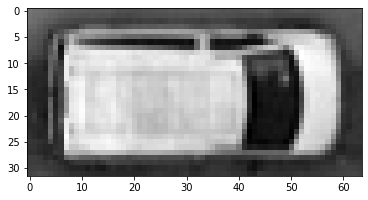

In [7]:
plt.imshow(cars_resized[1040], cmap="gray")

In [8]:
X = np.array(cars_resized, dtype=float).reshape(-1, r*c)
X.shape

(4302, 2048)

In [9]:
pca = PCA().fit(X)

In [10]:
singular_values = pca.singular_values_
components = pca.components_
components.shape

(2048, 2048)

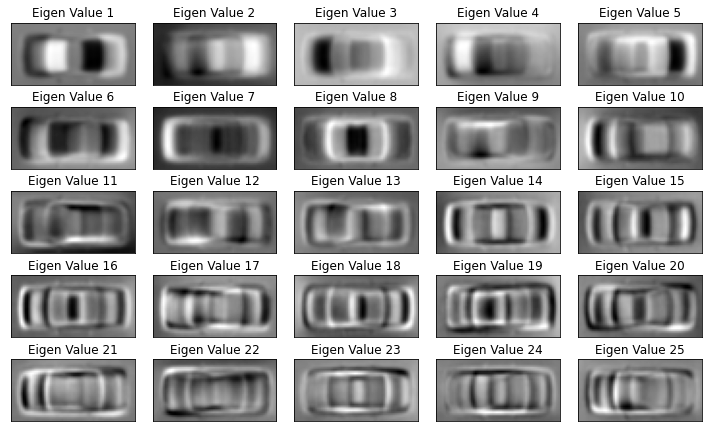

In [11]:
fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = components[i, :].reshape(r, c).copy()
    img /= img.max()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,  cmap="gray")
    plt.title("Eigen Value %d" % i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

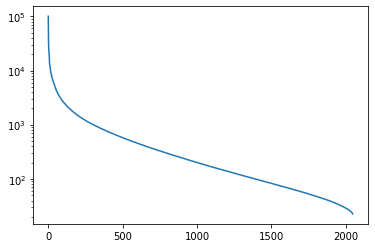

In [12]:
plt.plot(singular_values)
plt.yscale('log')

In [20]:
comp = components[:500]
mean = X.mean(axis=0)
X_pca = (X - mean).dot(comp.T) 
X_rec = X_pca.dot(comp) + mean

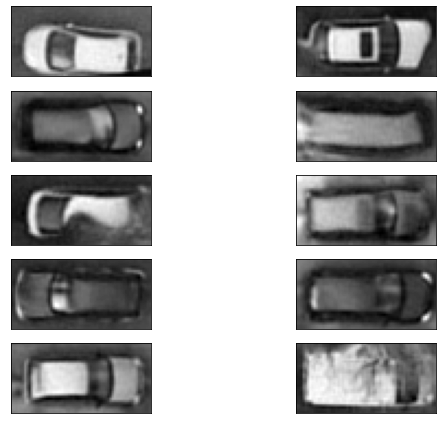

In [21]:
fig=plt.figure(figsize=(10, 6))
columns = 2
rows = 5
for i in range(1, columns*rows +1):
    img = X_rec[i-1, :].reshape(r, c)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

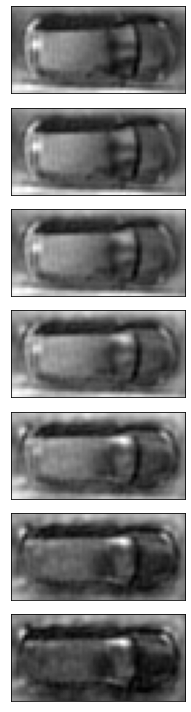

In [22]:
t = np.linspace(0, 1, 7)
a = X_pca[1000]
b = X_pca[25]
interpolate = []
for i in range(len(t)):
    interpolate.append(t[i]*a + (1 - t[i])*b)
interpolate = np.array(interpolate)
X_int = interpolate.dot(comp) + mean

fig=plt.figure(figsize=(3, 10))
columns = 1
rows = 7
for i in range(1, columns*rows +1):
    img = X_int[i-1, :].reshape(r, c)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

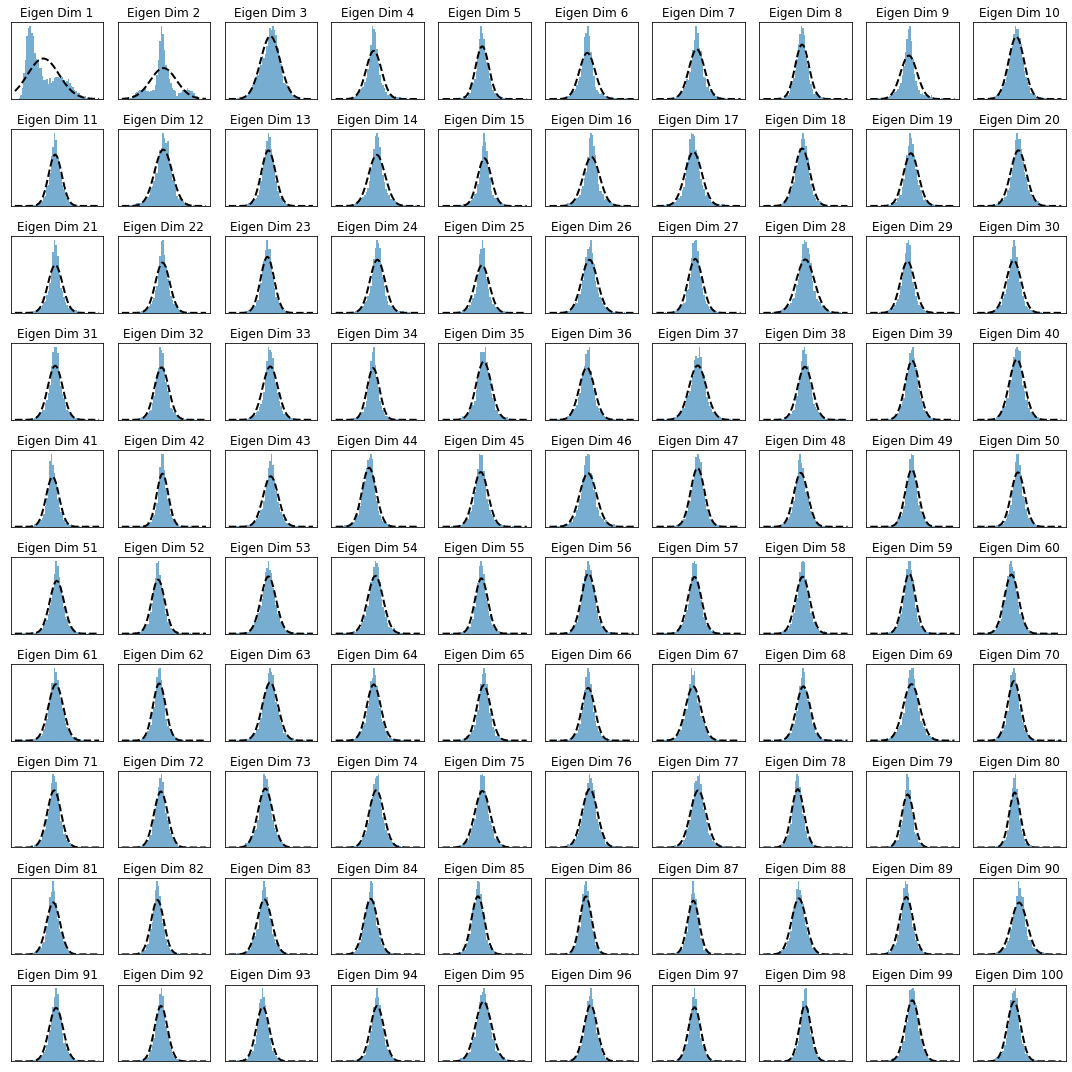

In [23]:
fig=plt.figure(figsize=(15, 15))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    dim = X_pca[:, i-1]
    fig.add_subplot(rows, columns, i)
    
    # data dist
    plt.hist(dim, bins=50, density=True, alpha=0.6)
    
    # fit gaus
    mu, std = dim.mean(), dim.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', linewidth=2)
    
    plt.title("Eigen Dim %d" % i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

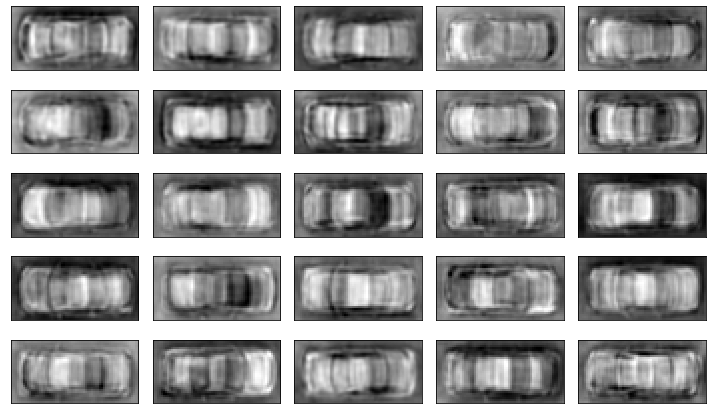

In [28]:
n = 25

rec_std =  X_pca.std(axis=0)
noise = np.random.normal(0, rec_std/2, [n, X_pca.shape[1]])

# pick first two dim from X_pca
idx = np.random.choice(X_pca.shape[0], n)
#noise[:, :2] = X_pca[idx, :2]

X_rec_noise = noise.dot(comp) + mean

fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = X_rec_noise[i-1, :].reshape(r, c)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

(30,)

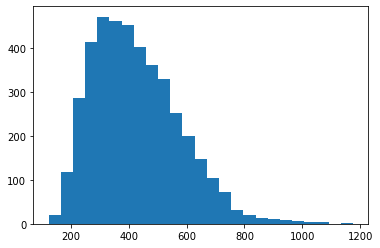

In [16]:
dist = np.linalg.norm(X - X_rec, axis=1)
_ = plt.hist(dist, bins=25)

idx = np.where(dist > 900)[0]
idx.shape

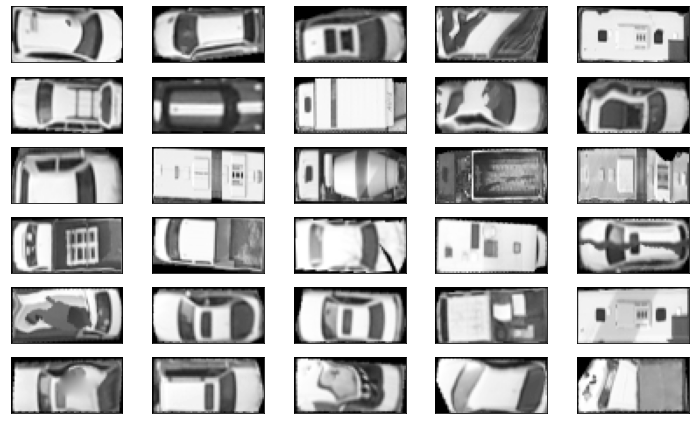

In [17]:
fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 6
for i in range(1, columns*rows +1):
    img = cars_resized[idx[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [26]:
!pip install torchsummary

In [20]:
from torchsummary import summary
import torchvision
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, TensorDataset

In [21]:
def conv_block(in_f, out_f, last=False):
    if not last:
        return nn.Sequential(
            nn.Conv2d(in_f, out_f, 3, bias=False, padding=1),
            nn.BatchNorm2d(out_f),
            nn.ReLU())
    return nn.Sequential(
            nn.Conv2d(in_f, out_f, 3, bias=True, padding=1),
            nn.Sigmoid())
def up_sample(in_f, out_f, use_convtranspose=False):
    if use_convtranspose:
        return nn.Sequential(
            nn.ConvTranspose2d(in_f, out_f, 2, stride=2, bias=False),
            nn.BatchNorm2d(out_f),
            nn.ReLU())  
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_f, out_f, 3, bias=False, padding=1),
        nn.BatchNorm2d(out_f),
        nn.ReLU())  

class AE(nn.Module):
    def __init__(self, out=3, ratio=1):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(out, 16*ratio),
            #conv_block(16*ratio, 16*ratio),
            nn.MaxPool2d((1, 2), (1, 2)),  
            conv_block(16*ratio, 32*ratio),  
            #conv_block(32*ratio, 32*ratio),
            nn.MaxPool2d(2, 2),  
            conv_block(32*ratio, 64*ratio),
            #conv_block(64*ratio, 64*ratio),
            nn.MaxPool2d(2, 2),
            conv_block(64*ratio, 64*ratio),
            conv_block(64*ratio, 64*ratio),
            nn.MaxPool2d(4, 4)
        )
        self.decoder = nn.Sequential(
            up_sample(64*ratio, 32*ratio),
            conv_block(32*ratio, 32*ratio),
            up_sample(32*ratio, 32*ratio),
            conv_block(32*ratio, 32*ratio),
            up_sample(32*ratio, 32*ratio), 
            conv_block(32*ratio, 32*ratio),
            up_sample(32*ratio, 16*ratio),
            conv_block(16*ratio, 16*ratio), 
            nn.Upsample(scale_factor=(1, 2)),
            conv_block(16*ratio, 16*ratio),
            conv_block(16*ratio, out, True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return 255*x

In [22]:
net = AE(3, 1).cuda()
summary(net, (3, 32, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 64]             432
       BatchNorm2d-2           [-1, 16, 32, 64]              32
              ReLU-3           [-1, 16, 32, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

In [23]:
r, c = 32, 64
cars = np.load("../data/potsdam_cars/cars.npy", allow_pickle=True)

cars_resized = []
for car in cars:
    car_resized = cv2.resize(car, (c, r))
    cars_resized.append(car_resized)
X = th.tensor(np.array(cars_resized, dtype=np.float32)).reshape(-1, 3, r, c)
X.shape

torch.Size([4205, 3, 32, 64])

In [24]:
dataset = TensorDataset(X, X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
optimizer = th.optim.Adam(net.parameters(), lr=0.001)
loss = th.nn.MSELoss(reduction="mean")

In [25]:
net.train()
learning_curve = []
for i in range(1, 200):
    l = 0
    for x, y in loader:
        optimizer.zero_grad()
        y_p = net.forward(x.cuda())
        output = loss(y_p, y.cuda())
        l += output.item()
        output.backward()
        optimizer.step()
    
    learning_curve.append(l)
    if i % 10 == 0:
        print("iteration ", i, "loss", l / len(loader))
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1

iteration  10 loss 713.0258918531014
iteration  20 loss 594.5781261559689
iteration  30 loss 439.42304275975084
iteration  40 loss 374.1688364202326
iteration  50 loss 351.28306579589844
iteration  60 loss 315.3585498694218
iteration  70 loss 301.85364359075373
iteration  80 loss 291.3438022497929
iteration  90 loss 276.3772884715687
iteration  100 loss 242.9266840616862
iteration  110 loss 243.35254021846887
iteration  120 loss 236.61514004794034
iteration  130 loss 234.35730708729136
iteration  140 loss 235.00399907430014
iteration  150 loss 232.4199651082357
iteration  160 loss 230.56513607140744
iteration  170 loss 229.65051939993194
iteration  180 loss 225.99919949155864
iteration  190 loss 222.2552059057987


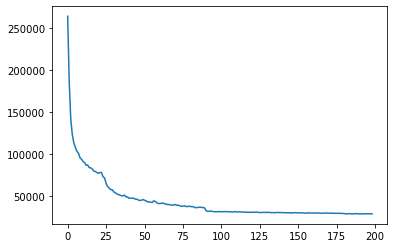

In [47]:
plt.plot(learning_curve)

In [27]:
cars_rec = []
net.eval()
for car in cars_resized:
    x = th.tensor(np.array(car, dtype=np.float32)).reshape(1, 3, r, c)
    y_p = net.forward(x.cuda()).cpu().detach().numpy().reshape(r, c, 3)
    cars_rec.append(y_p.copy()) 
cars_rec = np.array(cars_rec)
cars_rec.shape

(4205, 32, 64, 3)

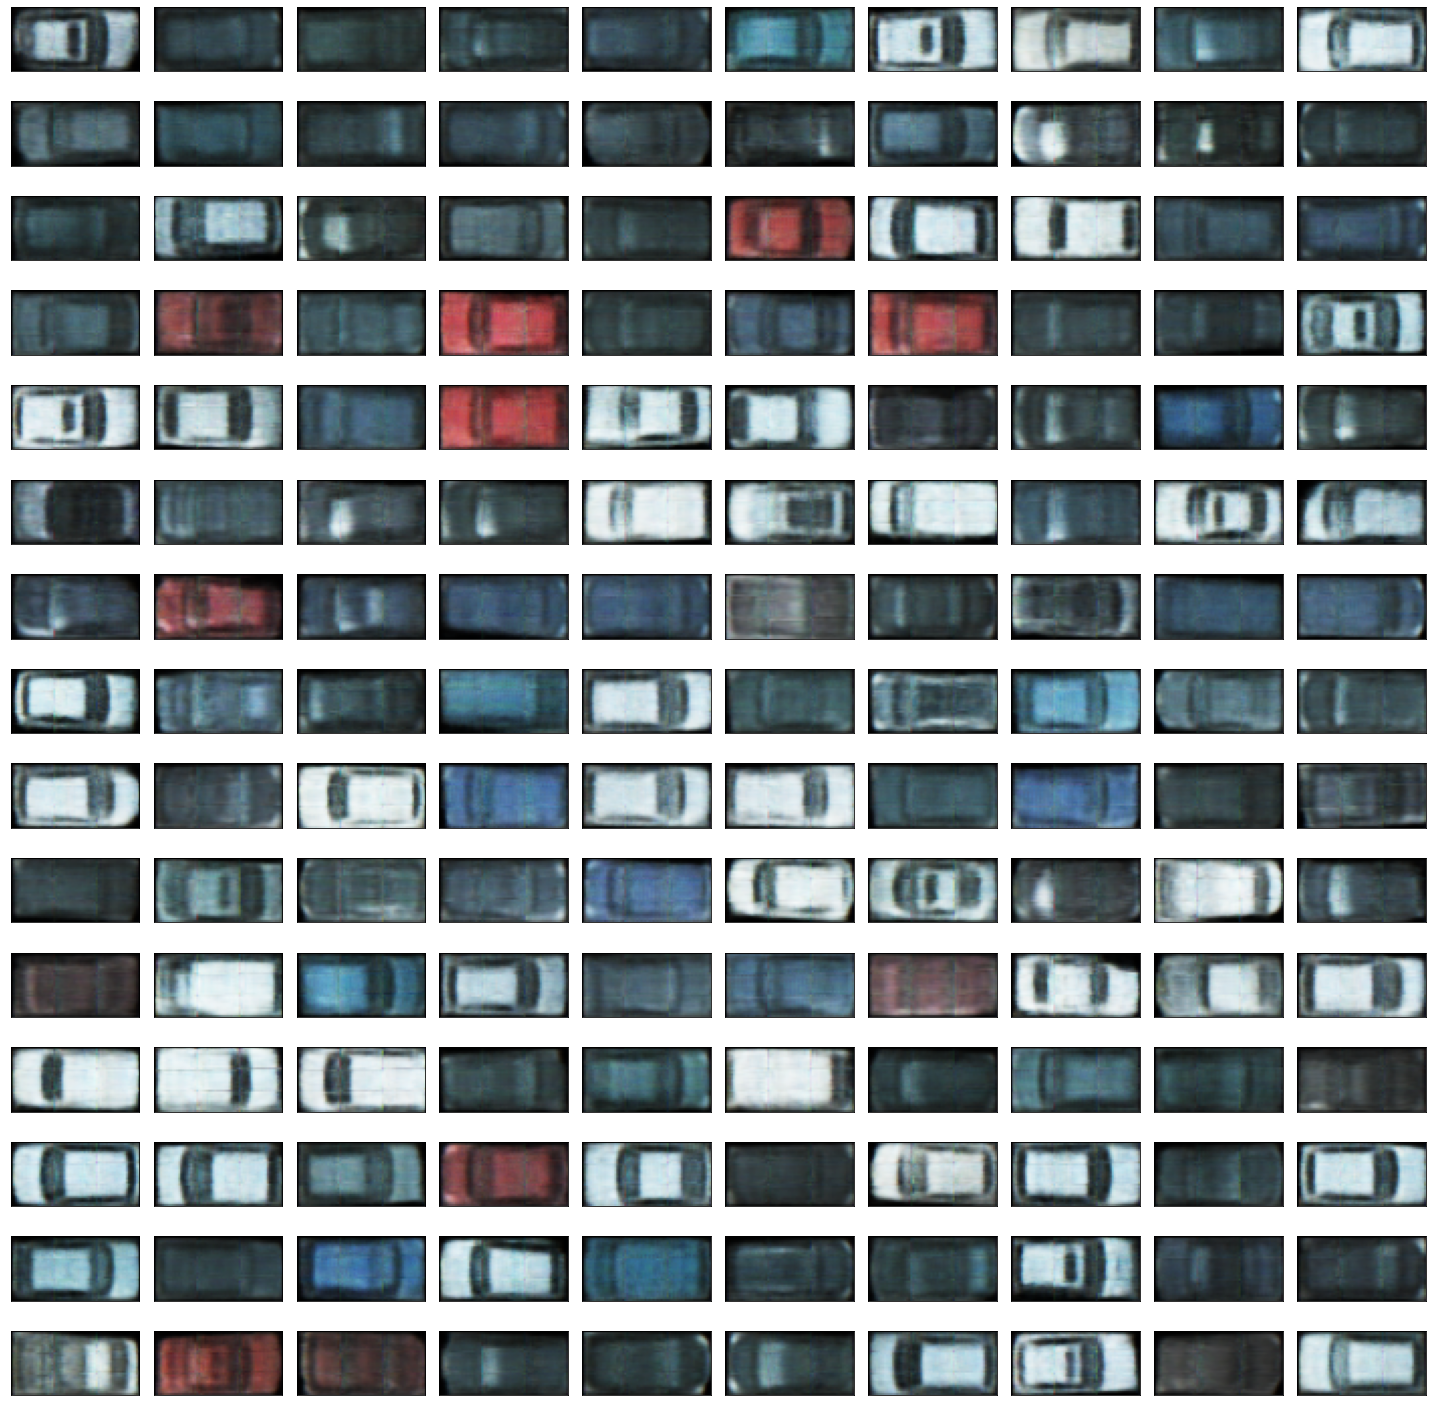

In [28]:
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 15
for i in range(1, columns*rows +1):
    img = np.array(cars_rec[i-1], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

(29,)

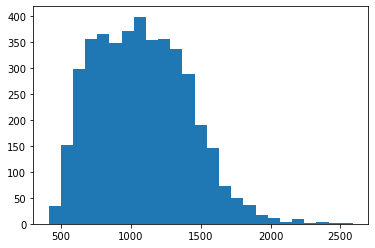

In [31]:
dist = np.linalg.norm(np.array(cars_resized, dtype=float).reshape(-1, r*c*3) \
                      - cars_rec.reshape(-1, r*c*3), axis=1)
_ = plt.hist(dist, bins=25)
idx = np.where(dist > 2000)[0]
idx.shape

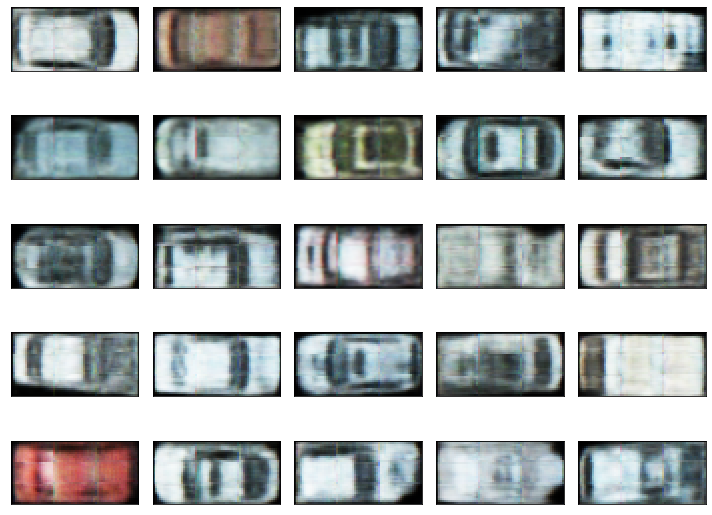

In [33]:
fig=plt.figure(figsize=(10, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = np.array(cars_rec[idx[i-1]], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

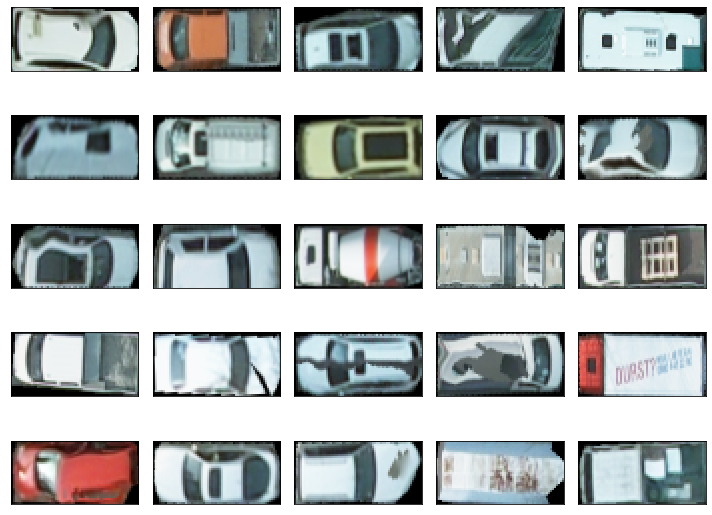

In [34]:
fig=plt.figure(figsize=(10, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = np.array(cars_resized[idx[i-1]], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [35]:
cars = np.load("../data/artificial_cars/cars.npy", allow_pickle=True)
r, c = 32, 64

cars_resized = []
for car in cars:
    car_resized = cv2.resize(car, (c, r))
    cars_resized.append(car_resized)

In [39]:
cars = np.load("../data/potsdam_cars_failed/cars.npy", allow_pickle=True)
r, c = 32, 64

cars_resized = []
for car in cars:
    cr, cc, _ = car.shape
    
    if cr < 20 or cc < 20:
        continue
    car_resized = cv2.resize(car, (c, r))
    cars_resized.append(car_resized)

In [40]:
cars_rec = []
net.eval()
for car in cars_resized:
    x = th.tensor(np.array(car, dtype=np.float32)).reshape(1, 3, r, c)
    y_p = net.forward(x.cuda()).cpu().detach().numpy().reshape(r, c, 3)
    cars_rec.append(y_p.copy()) 
cars_rec = np.array(cars_rec)
cars_rec.shape

(1609, 32, 64, 3)

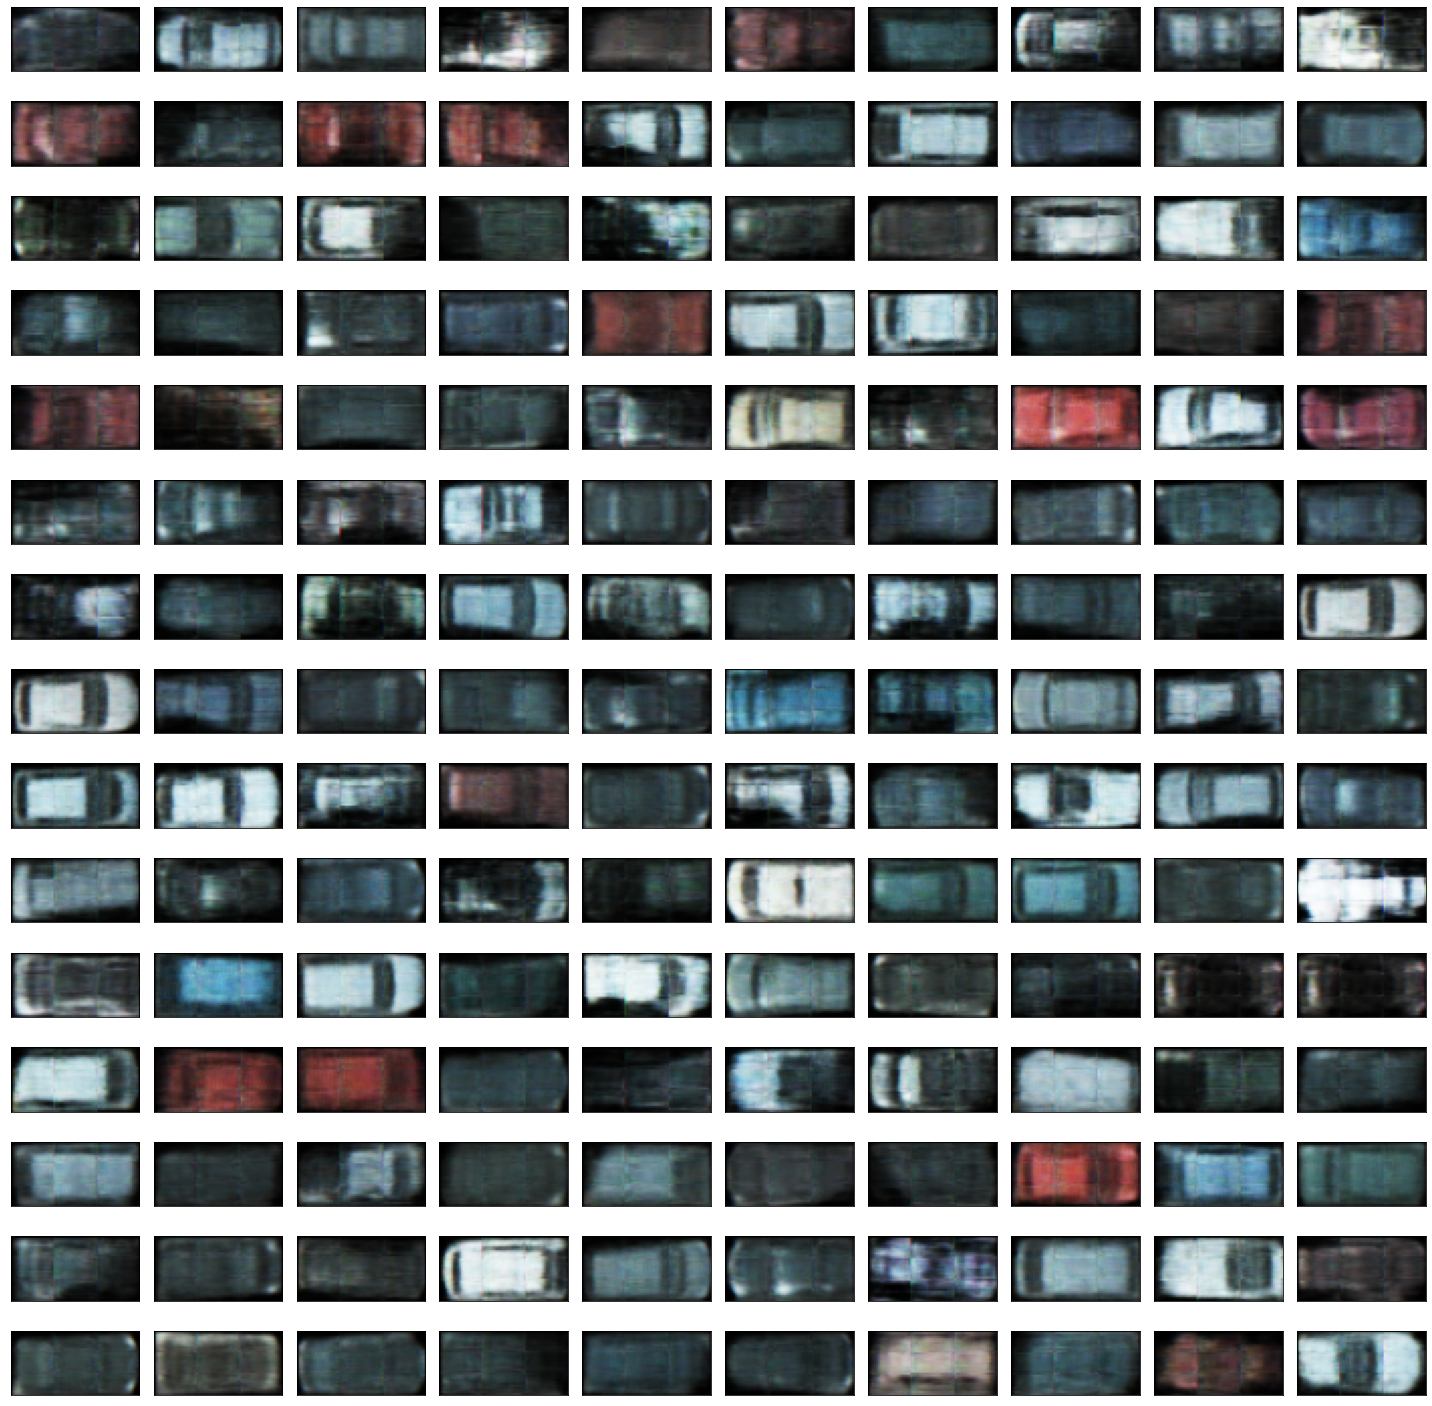

In [41]:
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 15
for i in range(1, columns*rows +1):
    img = np.array(cars_rec[i-1], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

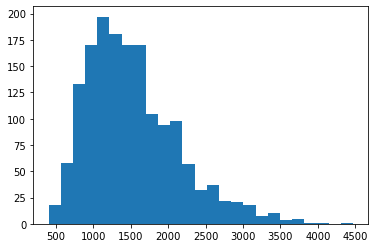

In [42]:
dist = np.linalg.norm(np.array(cars_resized, dtype=float).reshape(-1, r*c*3) \
                      - cars_rec.reshape(-1, r*c*3), axis=1)
_ = plt.hist(dist, bins=25)

In [43]:
idx = np.where(dist < 1000)[0]
idx.shape

(326,)

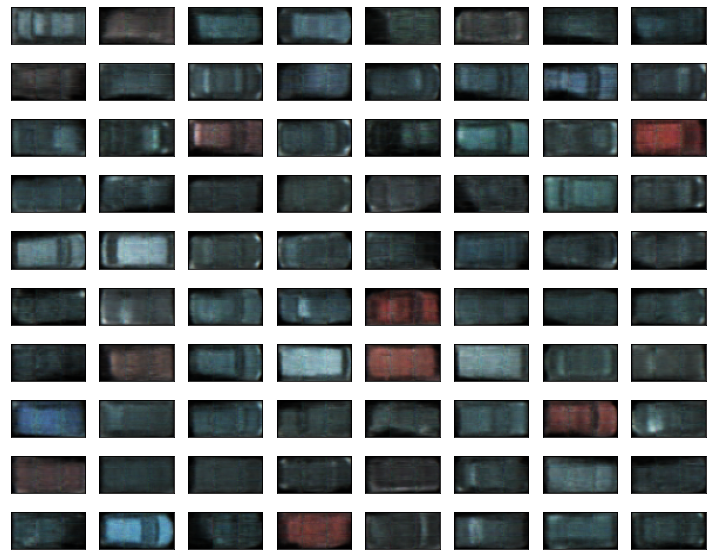

In [44]:
fig=plt.figure(figsize=(10, 8))
columns = 8
rows = 10
for i in range(1, columns*rows +1):
    img = np.array(cars_rec[idx[i-1]], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

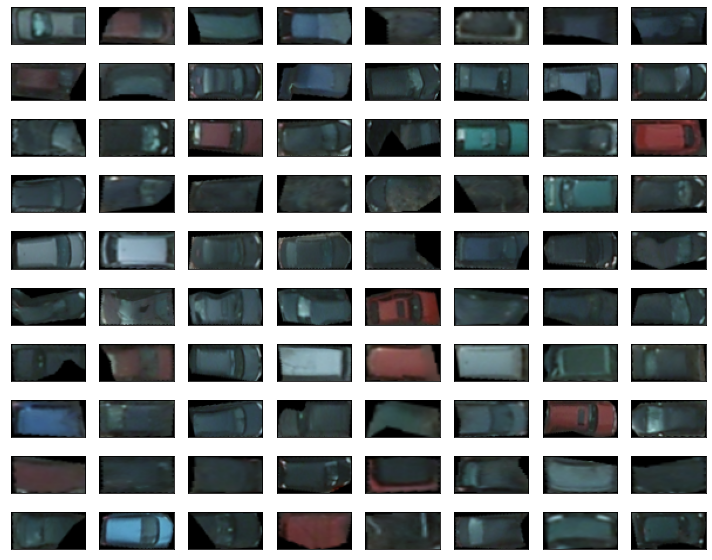

In [45]:
fig=plt.figure(figsize=(10, 8))
columns = 8
rows = 10
for i in range(1, columns*rows +1):
    img = np.array(cars_resized[idx[i-1]], dtype=int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
cars_save = [cars_resized[i] for i in idx]

In [ ]:
save_cars(cars_save, "test")